In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import math
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn import metrics

In [4]:
from random_dataset import create_random_dataset
from evolutionary_algorithm import EA
from greedy_algorithm import GreedyAlgorithm
from neg_sel import NegativeSelection, load_data

# Peptides

In [3]:
sampled_peptides_data_dir = "./data/sampled/"
peptides_data_dir = "./data/peptides/"

self1_data = pd.read_csv(peptides_data_dir + "self1-6mers.txt", header=None)

self1_data

,0
0,WFIIFF
1,IDVNHY
2,DEMHMS
3,IHGLFC
4,EEMNSY
...,...
261995,LLGRMF
261996,PSLMLL
261997,GMAYPR
261998,DALTEV


## Random Sampling

In [ ]:
random_dataset = create_random_dataset(df=self1_data, n=2000, seed=42)

random_dataset_list = random_dataset[0].to_list()
random_dataset_list

['SDRIAF',
 'LAELLN',
 'VCDEFF',
 'ASIHVP',
 'VNGPYA',
 'ALFTIL',
 'LELLER',
 'LIGSLA',
 'DEARDG',
 'LVFVRN',
 'CQMISA',
 'MDGYCM',
 'FGTLMG',
 'FFVLGL',
 'LVSSLL',
 'LAVNHS',
 'LKMTLL',
 'ISLIIN',
 'AGGTAL',
 'MQLGTL',
 'MRTLDN',
 'GVTLGL',
 'IFAAPT',
 'LAACFW',
 'RKTLDP',
 'NSSLEE',
 'GDTMVV',
 'IDSWMS',
 'FQGIIN',
 'FALIFL',
 'FTHLVV',
 'TWLLCT',
 'ISNLIT',
 'SNIPPS',
 'CYGRDQ',
 'KEVLEI',
 'AFVETS',
 'AAGLRL',
 'VPGMNM',
 'FLKLLT',
 'ANEAAA',
 'LSFASI',
 'VRGHWF',
 'VLAQQY',
 'SKPLIM',
 'LAAHRF',
 'IWGTDV',
 'FTEATR',
 'YKDTIQ',
 'LLLMFE',
 'LRSVHS',
 'NFHMFD',
 'DDEEFA',
 'LEWTIY',
 'LSAITN',
 'EGIMFS',
 'SVCYQY',
 'LQSLME',
 'CLGLLC',
 'LHYLWA',
 'TAKVPE',
 'FNGGMA',
 'WMIQSQ',
 'WWHRHH',
 'MMILGQ',
 'GHHLQG',
 'PLCLHQ',
 'QYLCRF',
 'WNVVKT',
 'KQEINA',
 'PWPARP',
 'FLGTCA',
 'MNGVTG',
 'NPLFLK',
 'GCRELA',
 'FFVANA',
 'FAKPFL',
 'HPDMAK',
 'VDAKHE',
 'MDTLFI',
 'FMPYNY',
 'LEVYRL',
 'YGSLFP',
 'PVVLPL',
 'VVPLST',
 'LGNYIA',
 'YLDQGG',
 'ARLNYL',
 'IACVSP',
 'DSIGFS',
 'QRIAAL',

In [28]:
with open(sampled_peptides_data_dir + "self1_6mers_random.txt", "w") as f:
    for item in random_dataset_list:
        f.write(f"{item}\n")

## Peptide Preperations and Fitness Function

In [4]:
peptides = self1_data[0].tolist()
peptide_length = len(peptides[0])

position_counts = [defaultdict(int) for _ in range(peptide_length)]

# count frequencies per position
for peptide in peptides:
    for i, aa in enumerate(peptide):
        position_counts[i][aa] += 1

# convert counts to frequencies
position_freqs = []
for pos in position_counts:
    total = sum(pos.values())
    pos_freq = {aa: count / total for aa, count in pos.items()}
    position_freqs.append(pos_freq)


def compute_Fpep(peptide, position_freqs):
    return sum(position_freqs[i].get(aa, 0) for i, aa in enumerate(peptide))


fpep_scores = [compute_Fpep(p, position_freqs) for p in peptides]

fpep_scores

[0.37046946564885497,
 0.34214503816793895,
 0.31243893129770994,
 0.45534351145038165,
 0.308206106870229,
 0.39288167938931295,
 0.3587213740458015,
 0.3714351145038168,
 0.3233931297709924,
 0.327793893129771,
 0.4612251908396947,
 0.22970610687022902,
 0.36521374045801525,
 0.46572519083969466,
 0.41359541984732817,
 0.27366030534351143,
 0.4122862595419848,
 0.3048435114503817,
 0.6128358778625954,
 0.4230801526717557,
 0.4459923664122137,
 0.38794656488549617,
 0.36055725190839694,
 0.35133206106870224,
 0.3815496183206107,
 0.43906870229007633,
 0.5297709923664122,
 0.31613358778625955,
 0.3573053435114504,
 0.36460305343511445,
 0.5421106870229008,
 0.2218053435114504,
 0.5223931297709924,
 0.448469465648855,
 0.5231259541984733,
 0.4818015267175572,
 0.28482061068702286,
 0.42503816793893134,
 0.26506106870229007,
 0.4940190839694657,
 0.4010687022900763,
 0.3785419847328244,
 0.3408053435114504,
 0.4888740458015267,
 0.3559465648854962,
 0.514618320610687,
 0.2693091603053435

## Greedy Algorithm

In [ ]:
amino_acids = "ACDEFGHIKLMNPQRSTVWY"

motifs = ["".join(motif) for motif in product(amino_acids, repeat=6)]

print(f"Total number of motifs: {len(motifs)}")

In [ ]:
# greedy_optimizer = GreedyAlgorithm(
#     peptides=self1_data[0].tolist(),
#     motifs=motifs,
#     t=3,
#     seed=42
# )

# for now, let's limit the lists due to computational constraints
greedy_optimizer = GreedyAlgorithm(peptides=self1_data[0].tolist()[0:200], motifs=motifs[0:20000], t=3, seed=42)
self1_optimized_data = greedy_optimizer.run()
self1_optimized_data

In [ ]:
print(f"Size of greedily optimized data set: {len(self1_optimized_data)}")

Size of greedily optimized data set: 197


In [ ]:
with open(sampled_peptides_data_dir + "self1_6mers_greedy.txt", "w") as f:
    for item in self1_optimized_data:
        f.write(f"{item}\n")

## Evolutionary Algorithm

In [5]:
def fitness(fpep_scores_set):
    if len(fpep_scores_set) == 0:
        return np.inf

    # Minimize avg fpep
    avg_fpep = np.mean(fpep_scores_set)

    # Maximize different kinds of fpep
    different_fpep = np.var(fpep_scores_set)

    # 1 & 0    is the same as what we had before
    weight_avg = 1
    weight_different = -3.0

    return (weight_avg * avg_fpep) + (weight_different * different_fpep)

In [6]:
## Standard Values across both Algorithms
sigma_val = 30

In [7]:
ea = EA(data=fpep_scores, N=100, sigma=sigma_val, K=2, p=0.1, mu=0.01, T=1000, f=np.mean, seed=42)
best_individual, best_fitness, fitness_avg, fitness_best = ea.run()

m_ea = EA(data=fpep_scores, N=100, sigma=sigma_val, K=2, p=0.1, mu=0.01, T=1000, f=fitness, seed=42)
multi_best_individual, multi_best_fitness, multi_fitness_avg, multi_fitness_best = m_ea.run()

Gen 1: Best = 0.3683291348600509, Avg = 0.41470220101781174
Gen 101: Best = 0.2999413486005089, Avg = 0.31141964631043256
Gen 201: Best = 0.29570737913486006, Avg = 0.3161786335877862
Gen 301: Best = 0.2891218829516539, Avg = 0.3078026463104325
Gen 401: Best = 0.295132951653944, Avg = 0.30783225826972005
Gen 501: Best = 0.28661628498727737, Avg = 0.3135435050890585
Gen 601: Best = 0.29752111959287525, Avg = 0.312830844783715
Gen 701: Best = 0.2971847328244275, Avg = 0.3122498269720102
Gen 801: Best = 0.27688282442748086, Avg = 0.29950462468193384
Gen 901: Best = 0.28428893129771, Avg = 0.3061818460559796
Gen 1: Best = 0.35032941488447644, Avg = 0.3886159918027659
Gen 101: Best = 0.2688878446285182, Avg = 0.2847311646608225
Gen 201: Best = 0.2703764447784221, Avg = 0.28474213528267295
Gen 301: Best = 0.27151680824252666, Avg = 0.2838433005882126
Gen 401: Best = 0.261502582566284, Avg = 0.2791352273582362
Gen 501: Best = 0.2671951497814813, Avg = 0.2852233843733368
Gen 601: Best = 0.2691

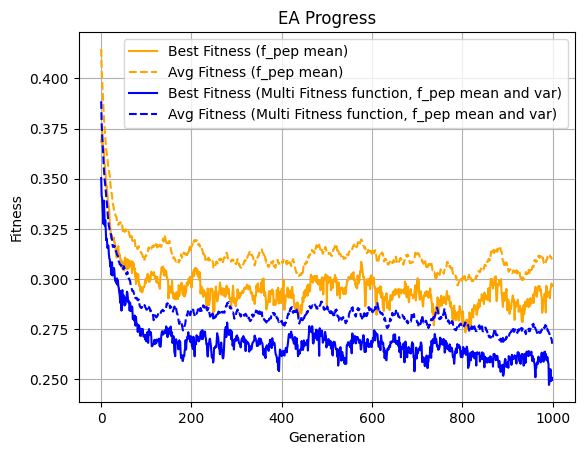

In [8]:
plt.plot(fitness_best, label="Best Fitness (f_pep mean)", linestyle="-", color="orange")
plt.plot(fitness_avg, label="Avg Fitness (f_pep mean)", linestyle="--", color="orange")
plt.plot(
    multi_fitness_best, label="Best Fitness (Multi Fitness function, f_pep mean and var)", linestyle="-", color="blue"
)
plt.plot(
    multi_fitness_avg, label="Avg Fitness (Multi Fitness function, f_pep mean and var)", linestyle="--", color="blue"
)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("EA Progress")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
optimal_peptides = [peptides[i] for i in best_individual]
optimal_peptides

['GSYRTL',
 'PAPWPV',
 'IYTFNQ',
 'SHGTAD',
 'FFFPFY',
 'AARIFG',
 'HGHMGY',
 'QADSEK',
 'RKDWFM',
 'QDAMCE',
 'DKYMPQ',
 'TPNQMH',
 'QEHYNK',
 'HHDPDG',
 'PDTHWT',
 'MVTCFD',
 'MYMDVR',
 'CKWAMN',
 'HAEDWF',
 'CSYHWD',
 'HCRNSH',
 'HYDYID',
 'CSCSCN',
 'NLYMHQ',
 'SNDYVR',
 'FRHPKQ',
 'NDAHEF',
 'FIENRY',
 'ICEDYK',
 'MTQIQN']

In [10]:
multi_optimal_peptides = [peptides[i] for i in multi_best_individual]
multi_optimal_peptides

['KDWMRP',
 'HCTECV',
 'MEYGEE',
 'AEAEMH',
 'IGGLLL',
 'DVYMIM',
 'KYYPRW',
 'PPVQTW',
 'KGQIPE',
 'QINGIN',
 'PNDMYD',
 'TRDWSI',
 'MEWLNS',
 'NQKGEC',
 'RCGQMM',
 'NGVPCK',
 'NLYHNC',
 'VYTYNE',
 'AHQCFR',
 'YCAHMA',
 'FMHKMR',
 'HRRFRQ',
 'LTLLTA',
 'ETIDWK',
 'LVGVGL',
 'NVFRHW',
 'PPYWDN',
 'IIIFYG',
 'CCPPIA',
 'CLCNMY']

In [ ]:
with open(sampled_peptides_data_dir + "self1_6mers_ea_mean.txt", "w") as f:
    for item in optimal_peptides:
        f.write(f"{item}\n")

with open(sampled_peptides_data_dir + "self1_6mers_ea_multi.txt", "w") as f:
    for item in multi_optimal_peptides:
        f.write(f"{item}\n")

# Improved Evolutionary Algorithm

Gen 1: Best = -0.7311668877979769, Avg = 0.007334206426223817
Gen 101: Best = -1.815675496642761, Avg = -1.5579975405102082
Gen 201: Best = -1.7517338739993826, Avg = -1.5712833085360265
Gen 301: Best = -1.9050308799260165, Avg = -1.6723602815162915
Gen 401: Best = -1.8400407857814125, Avg = -1.5995542492288193
Gen 501: Best = -1.8802227267576037, Avg = -1.6692624113051104
Gen 601: Best = -1.8752307531201544, Avg = -1.6033483640843773
Gen 701: Best = -1.856295232046688, Avg = -1.6346927935964737
Gen 801: Best = -1.9656898955658022, Avg = -1.6361219070426183
Gen 901: Best = -2.1072254723060655, Avg = -1.7734515046931723


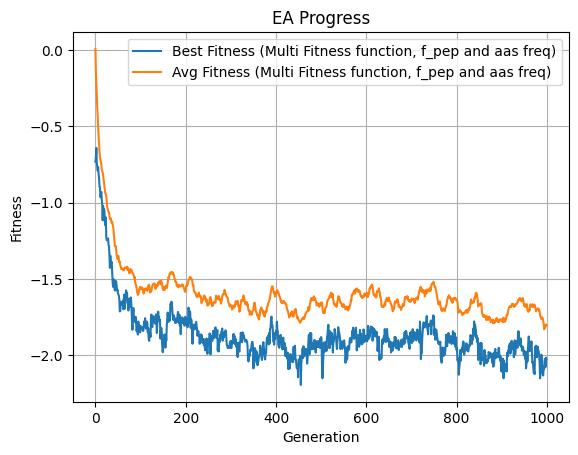

['IAYPPR',
 'KGHFDN',
 'QMRIKH',
 'VQQMWY',
 'AVVLDY',
 'TIPSWV',
 'CFGVTQ',
 'QYCAQD',
 'TNATIM',
 'MLYFQM',
 'WMPQEA',
 'HSQIDK',
 'CETCVF',
 'DRAYDY',
 'FGESIM',
 'FTVGHQ',
 'FKWWDN',
 'WKYHTH',
 'WCPQPW',
 'NRTEHF',
 'CTCRPG',
 'RFMMMR',
 'QYCDET',
 'MEDMDT',
 'MELQDC',
 'EHHTDW',
 'YWMNDA',
 'NNQIWN',
 'MPCNWW',
 'DFLCCQ']

In [12]:
peptides = self1_data[0].tolist()
peptide_length = len(peptides[0])

position_counts = [defaultdict(int) for _ in range(peptide_length)]

# count frequencies per position
for peptide in peptides:
    for i, aa in enumerate(peptide):
        position_counts[i][aa] += 1

# convert counts to frequencies
position_freqs = []
for pos in position_counts:
    total = sum(pos.values())
    pos_freq = {aa: count / total for aa, count in pos.items()}
    position_freqs.append(pos_freq)


def compute_Fpep(peptide):
    return sum(position_freqs[i].get(aa, 0) for i, aa in enumerate(peptide))


def compute_aa_frequency_scores(peptides):
    aa_counts = defaultdict(int)
    total_aa = 0

    for p in peptides:
        for aa in p:
            aa_counts[aa] += 1
            total_aa += 1

    aa_freqs = {aa: count / total_aa for aa, count in aa_counts.items()}

    def score(peptide):
        return sum(aa_freqs[aa] for aa in peptide)

    return [score(p) for p in peptides]


aa_freq_scores = compute_aa_frequency_scores(peptides)

feature_vectors = []
for i, peptide in enumerate(peptides):
    fpep = compute_Fpep(peptide)
    aa = aa_freq_scores[i]
    feature_vectors.append([fpep, aa])

scaler = StandardScaler()
feature_vectors = scaler.fit_transform(feature_vectors)


def composite_fitness(subset: np.ndarray):
    fpep_mean = np.mean(subset[:, 0])
    aa_mean = np.mean(subset[:, 1])

    return 1 * fpep_mean + 0.5 * aa_mean


m_ea = EA(data=feature_vectors, N=100, sigma=30, K=2, p=0.1, mu=0.02, T=1000, f=composite_fitness, seed=42)
multi_best_individual, multi_best_fitness, multi_fitness_avg, multi_fitness_best = m_ea.run()

plt.plot(multi_fitness_best, label="Best Fitness (Multi Fitness function, f_pep and aas freq)")
plt.plot(multi_fitness_avg, label="Avg Fitness (Multi Fitness function, f_pep and aas freq)")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("EA Progress")
plt.legend()
plt.grid(True)
plt.show()

multi_optimal_peptides = [peptides[i] for i in multi_best_individual]
multi_optimal_peptides

In [13]:
with open(sampled_peptides_data_dir + "self1_6mers_ea_impr.txt", "w") as f:
    for item in multi_optimal_peptides:
        f.write(f"{item}\n")

## Negative Selection

In [5]:
r_start = 1
r_stop = 6

In [11]:
ns = NegativeSelection(
    "/data/sampled/6mers.alpha", "./data/sampled/self1_6mers_greedy.txt", r_start=r_start, r_stop=r_stop
)

ns.run("./data/peptides/ebola-6mers.txt")
ns.run("./data/peptides/self2-6mers.txt")

### Calculate metrics of negative selection

In [7]:
def preprocess_data(data: pd.DataFrame, r: int):
    anomalous_data = data[data["anomalous"] == 1]
    sensitivity = len(anomalous_data[anomalous_data["score"] > r]) / len(anomalous_data)

    non_anomalous_data = data[data["anomalous"] == 0]
    specificity = len(non_anomalous_data[non_anomalous_data["score"] < r]) / len(non_anomalous_data)

    data["y"] = data["score"] > r

    return anomalous_data, non_anomalous_data, data


def caclulate_roc_auc(data):
    fpr, tpr, thresholds = metrics.roc_curve(data["anomalous"], data["score"])
    auc = metrics.roc_auc_score(data["anomalous"], data["score"])
    roc = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)

    return auc, roc

/home/vaggelis_spithas/Documents/ru/naco/projects/NaCo_Project/.naco310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vaggelis_spithas/Documents/ru/naco/projects/NaCo_Project/.naco310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


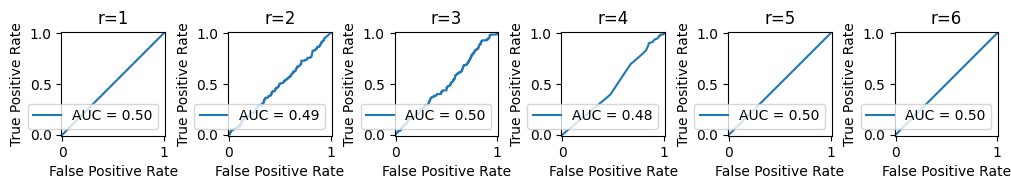

In [12]:
res_dir = "./data/results"
pd.set_option('future.no_silent_downcasting', True) # opt-in for future behavior of replace

fig, ax = plt.subplots(1, r_stop, figsize=(10, 10), constrained_layout=True)

acc_list = []
err_rate_list = []
f1_list = []
precision_list = []
recall_list = []

for r in range(r_start, r_stop + 1):
    anomalous_data = load_data("./data/peptides/ebola-6mers.txt", r, 1)
    normal_data = load_data("./data/peptides/self2-6mers.txt", r, 0)
    data = pd.concat([anomalous_data, normal_data])

    _, _, data = preprocess_data(data, r)
    # display(data.head())

    auc, roc = caclulate_roc_auc(data)
    axis = ax[r - 1]
    roc.plot(ax=axis)
    axis.set_title(f"r={r}")


    y_true = data['anomalous'].to_list()
    y_pred = data['y'].replace({True: 1, False: 0}).to_list()
    acc = metrics.accuracy_score(y_true, y_pred)
    err_rate = 1 - acc

    f1 = metrics.f1_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)

    acc_list.append(acc)
    err_rate_list.append(err_rate)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)

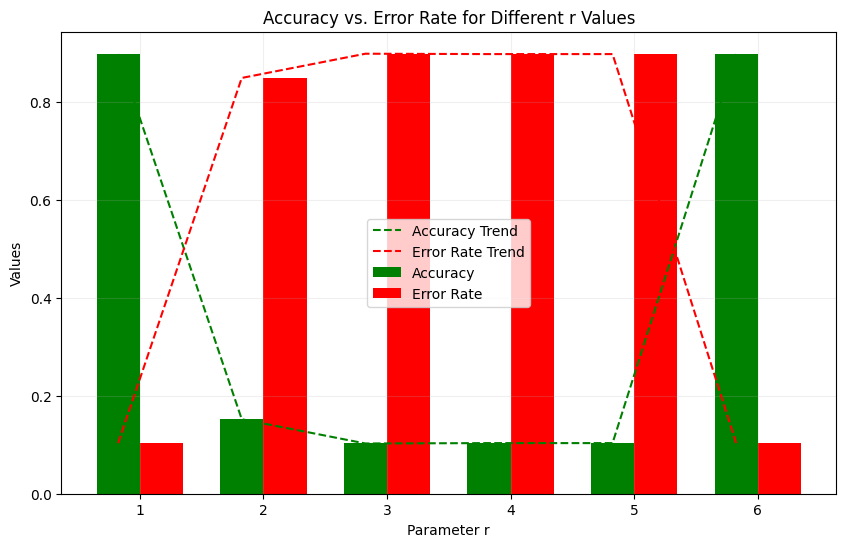

In [13]:
r_values = [r for r in range(r_start, r_stop + 1)]
bar_width = 0.35
x = np.arange(len(r_values))

plt.figure(figsize=(10, 6))

plt.bar(x, acc_list, bar_width, label='Accuracy', color='green')
plt.bar(x + bar_width, err_rate_list, bar_width, label='Error Rate', color='red')

# Add trend lines for accuracy and error rates
# Use moving average for the trend line (smooth line)
window = 1  # Number of points to average over
accuracy_trend = np.convolve(acc_list, np.ones(window)/window, mode='valid')
error_trend = np.convolve(err_rate_list, np.ones(window)/window, mode='valid')

plt.plot(x[window-1:], accuracy_trend, 'g--', label='Accuracy Trend')
plt.plot(x[window-1:], error_trend, 'r--', label='Error Rate Trend')

plt.xlabel('Parameter r')
plt.ylabel('Values')
plt.title('Accuracy vs. Error Rate for Different r Values')
plt.xticks(x + bar_width / 2, r_values)  # Center the x-tick labels
plt.legend()
plt.grid(True, alpha=0.2)

plt.show()

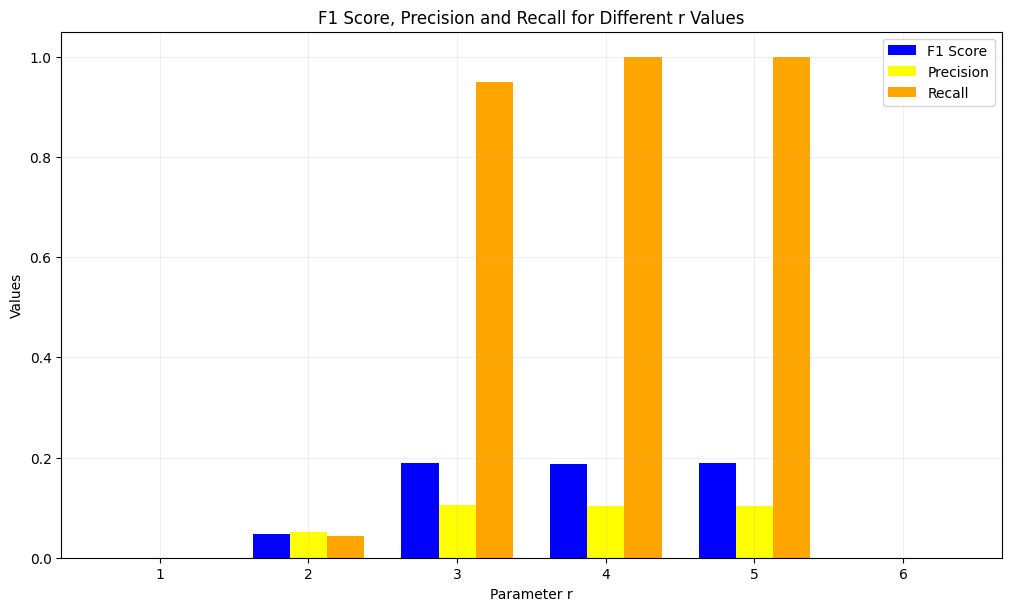

In [10]:
bar_width = 0.25

# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(layout='constrained', figsize=(10, 6))

ax.bar(x, f1_list, bar_width, label='F1 Score', color='blue')
ax.bar(x + bar_width, precision_list, bar_width, label='Precision', color='yellow')
ax.bar(x + 2*bar_width, recall_list, bar_width, label='Recall', color='orange')


ax.set_xlabel('Parameter r')
ax.set_ylabel('Values')
ax.set_title('F1 Score, Precision and Recall for Different r Values')
ax.legend()
ax.set_xticks(x + bar_width, r_values)
ax.grid(True, alpha=0.2)

plt.show()